<a href="https://colab.research.google.com/github/YixinFan11/data-science/blob/master/Technical_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Project

## Loading data and set options



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 4000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 1000)

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install openpyxl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = "/content/drive/MyDrive/data_task.xlsx"
df_order_numbers =  pd.read_excel(file_path, sheet_name='order_numbers')
df_transaction_data =  pd.read_excel(file_path, sheet_name='transaction_data')
df_reported_data =  pd.read_excel(file_path, sheet_name='reported_data')

## Data Preprocessing


In [5]:
# Define plot function
def plot_over_time(df, y_axis):
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[y_axis], label = y_axis, color='blue')

    plt.title(y_axis + 'Over Time')
    plt.xlabel('Date')
    plt.ylabel(y_axis)
    plt.show()


### Order Numbers

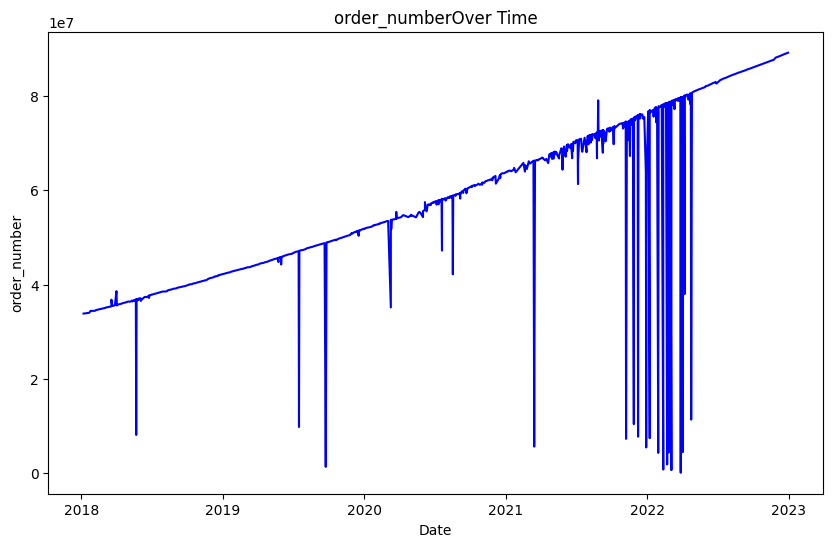

In [6]:
plot_over_time(df_order_numbers, 'order_number')

Based on the observation of order numbers, there are several conditions that need to be dealt with:


*   Large Outlier. The order number experience a sudden sharp increase and it is higher than several subsequent order numbers.
*   Bad datapoint. When the order number decreases, it is clearly wrong record and should be dealt with.
*   Multiple date. If there are repeated date after finishing the above two processes, this should also be dealt with.






In [7]:
def remove_large_diff_outliers(df, threshold, target_cloumn):
    """
    Removes rows where the difference between consecutive order numbers exceeds the given threshold.
    """
    df[target_cloumn + '_diff'] = df[target_cloumn].diff()
    df_cleaned = df.drop(df[df[target_cloumn + '_diff'] > threshold].index)
    return df_cleaned

def remove_decreasing_orders(df, target_cloumn):
    """
    Removes rows where the order number is smaller than the maximum order number observed so far.
    """
    df[target_cloumn + '_max'] = df[target_cloumn].cummax()
    df_cleaned = df.loc[(df[target_cloumn + '_max'] - df[target_cloumn]) <= 0]
    return df_cleaned

def main_clean_process(df, threshold, target_cloumn):
    """
    Cleans the order numbers data by removing outliers and abnormal decreasing order numbers.
    """
    # Remove large difference outliers
    df_cleaned = remove_large_diff_outliers(df, threshold, target_cloumn)

    # Remove abnormal decreasing order numbers
    df_cleaned = remove_decreasing_orders(df_cleaned, target_cloumn)

    # Select relevant columns for the cleaned DataFrame
    df_cleaned = df_cleaned[['date', target_cloumn]]

    return df_cleaned


In [8]:
# Applying the cleaning process to df_order_numbers
df_order_numbers_cleaned = main_clean_process(df_order_numbers, 1000000, 'order_number')

### Transaction Data

In [9]:
def normalising_by_mean(df, numerator_column, denominator_column, new_column_name):

    # Normalize the numerator by the denominator
    df[new_column_name] = df[numerator_column] / df[denominator_column]

    return df

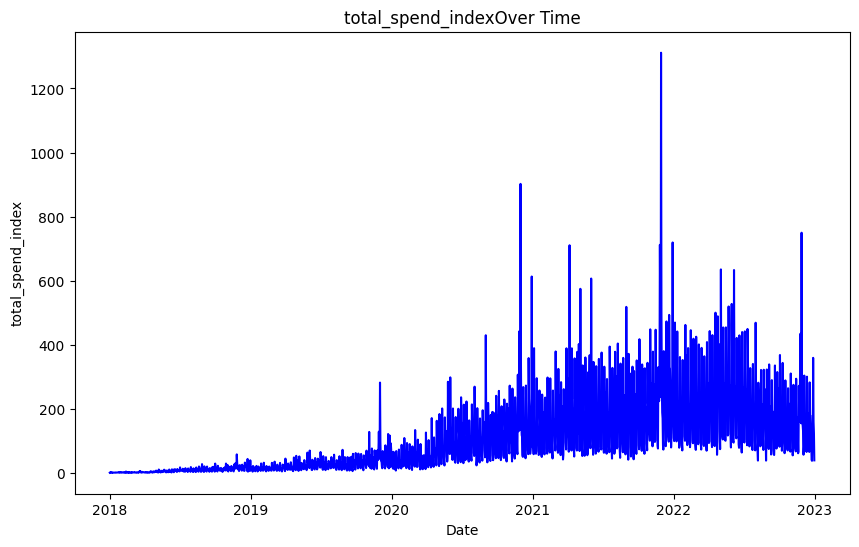

In [10]:
plot_over_time(df_transaction_data, 'total_spend_index')

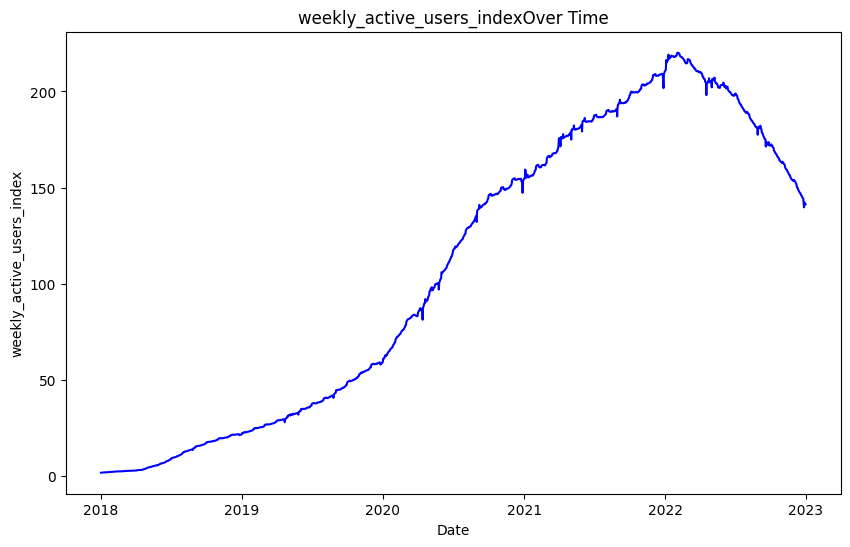

In [11]:
plot_over_time(df_transaction_data, 'weekly_active_users_index')


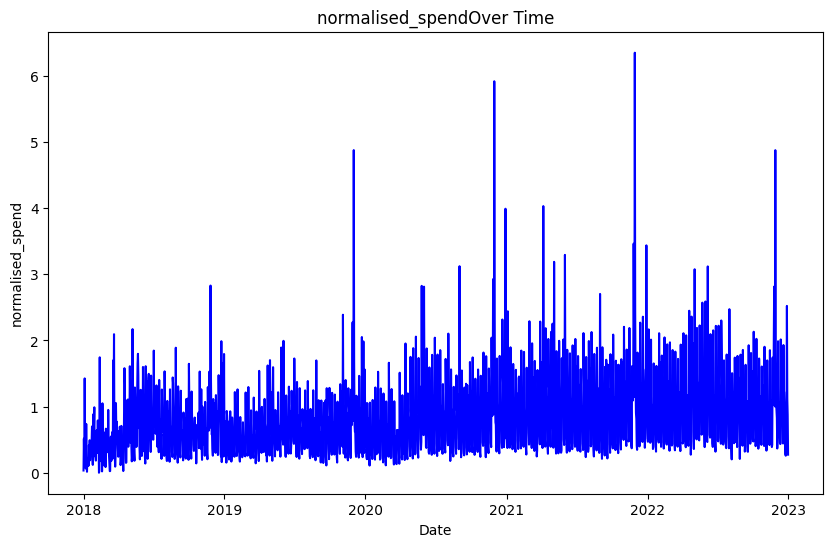

In [12]:
# Create a new cloumn measuring spend per active user to normalised these two cloumns.
df_transaction_data_cleaned = normalising_by_mean(df_transaction_data, 'total_spend_index', 'weekly_active_users_index', 'normalised_spend')
df_transaction_data_final = df_transaction_data_cleaned[['date', 'normalised_spend']]

plot_over_time(df_transaction_data, 'normalised_spend')


### Group the data

In [13]:
# define a function that could assign the period to the dataframe df_reported_data
def assign_period(df, df_reported_data):
    """
    Assigns the correct period to the rows in df based on the date and df_reported_data's start and end dates.
    """
    df_reported_data['end_date'] = pd.to_datetime(df_reported_data['end_date'])
    df['date'] = pd.to_datetime(df['date'])
    df['period'] = None
    index = 0
    for i,row in df.iterrows():
        current_date = row['date']
        while current_date > df_reported_data.loc[index, 'end_date'] and index < len(df_reported_data) - 1:
            index += 1
        df.loc[i, 'period'] = df_reported_data.loc[index, 'period']
    return df


def period_mean(df, column_name):
    """
    Groups the dataframe by 'period' and calculates the mean for the specified column.
    """
    df_group_mean = df.groupby('period')[column_name].mean().reset_index()
    return df_group_mean


def period_growth(df, column_name):
    """
    Calculates the growth (difference) between consecutive periods for the specified column.
    The growth is calculated as the difference between the last value of the current period and the last value of the previous period.
    For the first period, the growth is calculated as the difference between the first and last values.
    """
    new_column_name = column_name + '_by_growth'

    # get the last value of each group
    df_group_difference = df.groupby('period')[column_name].last().reset_index()

    # take the difference
    df_group_difference[new_column_name] = df_group_difference[column_name].diff()


    df_group_first_value = df.groupby('period')[column_name].first().reset_index()

    # the first value: assign the last value of the first group to the first row
    df_group_difference[new_column_name].iloc[0] = df_group_difference[column_name].iloc[0] - df_group_first_value[column_name].iloc[0]

    return df_group_difference[['period', new_column_name]]


def period_length(df, period_start_date, period_end_date):
    """
    Adds a column to the dataframe that calculates the length of each period in days.
    """

    df[period_start_date] = pd.to_datetime(df[period_start_date])
    df[period_end_date] = pd.to_datetime(df[period_end_date])

    # Calculate the length of each period in days
    df['period_length'] = (df[period_end_date] - df[period_start_date]).dt.days + 1

    return df


In [14]:
# Assign periods to the order number and transaction data
df_order_number_with_period = assign_period(df_order_numbers_cleaned, df_reported_data)
df_transaction_data_with_period = assign_period(df_transaction_data_final, df_reported_data)

# Calculate the growth of order numbers by period
df_order_number_quartered = period_growth(df_order_number_with_period, 'order_number')
# Calculate the mean of normalized spend by period
df_transaction_data_quartered = period_mean(df_transaction_data_with_period, 'normalised_spend')

# Merge the dataframes
df_final = df_reported_data.copy()
df_final = pd.merge(df_final, df_order_number_quartered,  on='period')
df_final = pd.merge(df_final, df_transaction_data_quartered,  on='period')

# Calculate period length
# then normalize order_number_by_growth by period_length and store it in order_number_per_day
df_final = period_length(df_final,'start_date','end_date')
df_final = normalising_by_mean(df_final, 'order_number_by_growth', 'period_length', 'order_number_per_day')

In [15]:
df_final

,period,start_date,end_date,revenue_index,order_number_by_growth,normalised_spend,period_length,order_number_per_day
0,2018 Q1,2018-01-01,2018-02-28,100.000000,737459.0,0.409458,59,12499.305085
1,2018 Q2,2018-03-01,2018-06-30,253.521127,3178413.0,0.677376,122,26052.565574
2,2018 Q3,2018-07-01,2018-08-31,139.788732,1324544.0,0.747407,62,21363.612903
3,2018 Q4,2018-09-01,2018-12-31,306.161972,3065524.0,0.732159,122,25127.245902
4,2019 Q1,2019-01-01,2019-02-28,117.693662,1321037.0,0.549906,59,22390.457627
5,2019 Q2,2019-03-01,2019-06-30,294.102113,3048557.0,0.688640,122,24988.172131
6,2019 Q3,2019-07-01,2019-08-31,156.514085,1674117.0,0.680344,62,27001.887097
7,2019 Q4,2019-09-01,2019-12-31,359.947183,3601784.0,0.775569,122,29522.819672
8,2020 Q1,2020-01-01,2020-02-29,148.063380,1641438.0,0.578690,60,27357.300000
9,2020 Q2,2020-03-01,2020-06-30,289.788732,4042425.0,0.761075,122,33134.631148


## Feature Selection

In [16]:
# Remove the '2018 Q1' period from df_final since in transaction data they are quite noisy
df_final = df_final[df_final['period'] != '2018 Q1']

# Select relevant columns for correlation analysis
df_final = df_final[['normalised_spend', 'period', 'order_number_per_day', 'revenue_index']]

# Calculate the absolute correlation between 'revenue_index' and other selected columns
corr_list = df_final[['normalised_spend', 'order_number_per_day', 'revenue_index']].corr()['revenue_index'].abs().sort_values(ascending=False)
display(corr_list)


# Calculate the absolute correlation between 'normalised_spend' and 'order_number_per_day'
corr_list_var = df_final[['normalised_spend', 'order_number_per_day']].corr().abs()
display(corr_list_var)


,revenue_index
revenue_index,1.000000
normalised_spend,0.743031
order_number_per_day,0.493219


,normalised_spend,order_number_per_day
normalised_spend,1.000000,0.650213
order_number_per_day,0.650213,1.000000


## Model Training

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

In [18]:
# Split into training and testing sets

train = df_final[df_final['period'] != '2022 Q4']
test = df_final[df_final['period'] == '2022 Q4']


X_train = train[['order_number_per_day', 'normalised_spend']]
y_train = train['revenue_index']
X_test = test[['order_number_per_day', 'normalised_spend']]
y_test = test['revenue_index']

In [19]:
# Linear Regression Model Training
def train_linear_regression(X_train, y_train):
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    return linear_model

In [20]:
# Decision Tree Model Training
def train_decision_tree(X_train, y_train):
    tree_model = DecisionTreeRegressor(random_state=0, max_depth=4)
    tree_model.fit(X_train, y_train)
    return tree_model

In [21]:
# XGBoost Model Training
def train_xgboost(X_train, y_train):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0, n_estimators=100, max_depth=4)
    xgb_model.fit(X_train, y_train)
    return xgb_model

## Model Evaluation

There are metrics used to evaluate the model performance:



*   The R-squared value (coefficient of determination) on the training data: This indicates how well the model fits the data it was trained on. It could be concluded that the model is good fit when the R-squared value is close to 1.
*   Root Mean Squared Error (RMSE): RMSE is a measure of how well the model performs on the test data. It could show the average error between the predicted values and the actual values.
*   Cross-validation MSE and standard deviation: These evaluates the model's generalizability. It divides the training data into several parts (folds) and trains and tests the model on different subsets of the data, providing a more reliable assessment of the model's performance. If they are high, the model is clearly overfitting.



In [22]:
def model_evaluation(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    r2_in_sample = r2_score(y_train, y_train_pred)
    print(f"In-sample R-squared for {model_name}: {r2_in_sample:.4f}")

    y_pred = model.predict(X_test)
    rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Predicted value for {model_name}: {y_pred}")
    print(f"Root Mean Squared Error for {model_name}: {rmse}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation MSE for {model_name}: {-cv_scores.mean()}, Standard Deviation for {model_name}: {cv_scores.std()}")

    print()

In [23]:
linear_model = train_linear_regression(X_train, y_train)
model_evaluation(linear_model, X_train, y_train, X_test, y_test, 'Linear Regression')

In-sample R-squared for Linear Regression: 0.5396
Predicted value for Linear Regression: [372.70509889]
Root Mean Squared Error for Linear Regression: 139.3746901291923
Cross-validation MSE for Linear Regression: 10748.173555906484, Standard Deviation for Linear Regression: 5937.890162138309



In [24]:
tree_model = train_decision_tree(X_train, y_train)
model_evaluation(tree_model, X_train, y_train, X_test, y_test, 'Decision Tree')

In-sample R-squared for Decision Tree: 0.9859
Predicted value for Decision Tree: [552.44298566]
Root Mean Squared Error for Decision Tree: 40.36319663852612
Cross-validation MSE for Decision Tree: 17064.39398670934, Standard Deviation for Decision Tree: 11855.284641639852



In [25]:
xgb_model = train_xgboost(X_train, y_train)
model_evaluation(xgb_model, X_train, y_train, X_test, y_test, 'XGB_Boost')

In-sample R-squared for XGB_Boost: 1.0000
Predicted value for XGB_Boost: [447.32913]
Root Mean Squared Error for XGB_Boost: 64.75065694262321
Cross-validation MSE for XGB_Boost: 13941.209037582952, Standard Deviation for XGB_Boost: 4337.680619093221



## Overall Conclusion

*   Linear Regression has poor performance, the lowest In-sample R-squared showing that it is underfitting and being unable to capture the complexity of the data. It also has the largest RMSE, showing that the prediction is far
*   Decision Tree shows perfect performance among these three with the lowest RMSE. However, with the highest cross-validation MSE and standard deviation, the model also suffer from significant overfitting.
*   XGB Boost shows great fit on the training date and the test data. It also shows a better stable performance comparing the other two model, since it has low cross-validation MSE and standard deviation.

Therefore, XGB Boost seems to be a good choice. It provides a better generalization comparing to the Decision Tree and has significantly better fit the data compring to Linear Regression.



